# Tennis Action Evaluator

## Introduction

### Problem

### Model Definition

#### State

#### Action

#### Rewards

### Data Processing

#### Raw Data

#### Extracted data

### Evaluation

We evaluate the model based on how well it estimates the actual probability that the agent at state $s$ performing action $a$ will win the rally.

We do this by passing a list of $(s,a)$ pairs to the estimator model to get the $Q(s,a)$ indicating the probability of the agent winning. Each $(s,a)$ pair has already been marked as belonging to the winner or the loser of the rally.

We deem a prediction correct in the following cases:
1. The $(s,a)$ pair belongs to the winner and gives a $Q(s,a) \ge 0.5$ 
2. The $(s,a)$ pair belongs to the loser and gives a $Q(s,a) \lt 0.5$

The final score of the model is calculated using $\frac{\text{correct predictions}}{\text{total predictions}}$.

## Approximated MC Learning

First, we tried a simple approximated MC learning to approximate the $Q(s,a)$ function as a baseline. This is a simple linear regression problem. We used `sklearn.linear_model.LinearRegression` to create an estimator model.

Since the reward of a tennis rally is only non-zero at the end of a rally, MC learning's behavior of looking at the accumulated rewards for an entire trial might be beneficial for estimating the Q-values of tennis actions.

### Training

Being that it is merely solving a system of linear equations, training of the estimator model is very quick for approximated MC learning.

In [1]:
import mc_learning as mc

mc_model = mc.train(save=False)
print(mc_model.coef_)

[[ 0.00046365  0.00620755  0.00934649 -0.02493163  0.0050135  -0.02148365
  -0.00191497 -0.00411411 -0.00643848  0.0220249  -0.00568214  0.02426598
   0.00129729 -0.00062967 -0.02203004  0.00634108 -0.00288176]]


### Evaluation

However, accuracy is low for this method, only correctly predicting the outcome of the $Q(s,a)$ correctly 53% of the time. The $Q(s,a)$ cannot be directly represented by a linear function of the features we have defined.

In [2]:
from data import test_dataset
import evaluation as eval

def mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = mc_model.predict(single_sample_reshape)
    return pred

score = eval.score_model(test_dataset, mc_predict)

print(f"Linear MC Learning Accuracy: {score}")

Linear MC Learning Accuracy: (0.5361596009975063, 0.24950967844844793)


## Deep Reinforcement Learning

### MC

#### Training

In [3]:
import d_sarsa

nn_mc_model, nn_mc_report = d_sarsa.train(save=False, use_mc=True)

EPOCH: 1.000  train_ave_loss: 0.252  train_ave_acc: 0.549  (3.03s - 88.01s remaining) ave_loss: 0.25200633014227286 ave_acc: 0.5492944762122528
EPOCH: 2.000  train_ave_loss: 0.241  train_ave_acc: 0.588  (5.79s - 81.03s remaining) ave_loss: 0.24095908485768128 ave_acc: 0.5879714058677192
EPOCH: 3.000  train_ave_loss: 0.237  train_ave_acc: 0.615  (8.58s - 77.24s remaining) ave_loss: 0.2369547048010085 ave_acc: 0.6154261942805689
EPOCH: 4.000  train_ave_loss: 0.234  train_ave_acc: 0.623  (11.34s - 73.70s remaining) ave_loss: 0.23393070059787494 ave_acc: 0.6232495511923382
EPOCH: 5.000  train_ave_loss: 0.231  train_ave_acc: 0.632  (14.11s - 70.56s remaining) ave_loss: 0.23096694778705623 ave_acc: 0.6318483521328448
EPOCH: 6.000  train_ave_loss: 0.231  train_ave_acc: 0.627  (16.94s - 67.77s remaining) ave_loss: 0.2306781192460368 ave_acc: 0.6271535267070721
EPOCH: 7.000  train_ave_loss: 0.226  train_ave_acc: 0.637  (19.74s - 64.86s remaining) ave_loss: 0.22621503141312654 ave_acc: 0.6372324

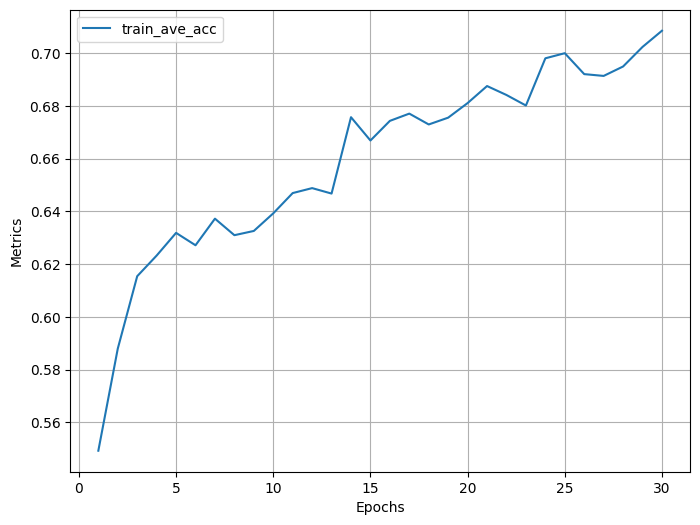

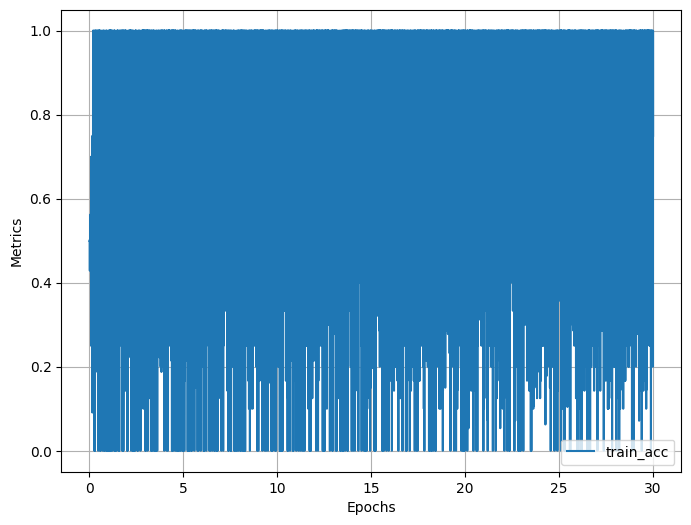

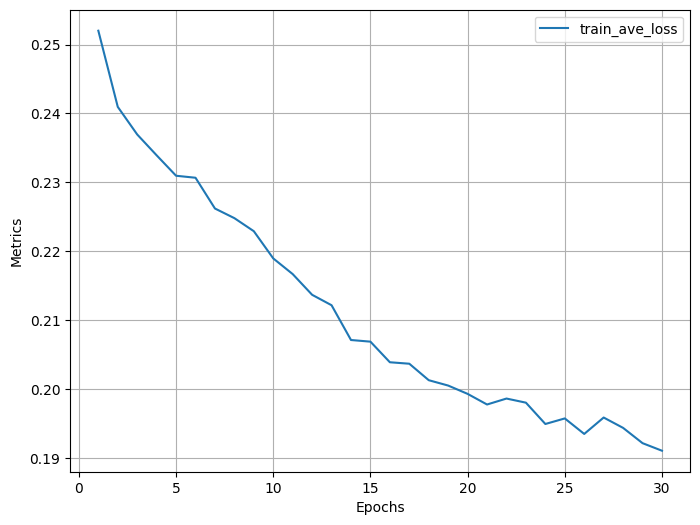

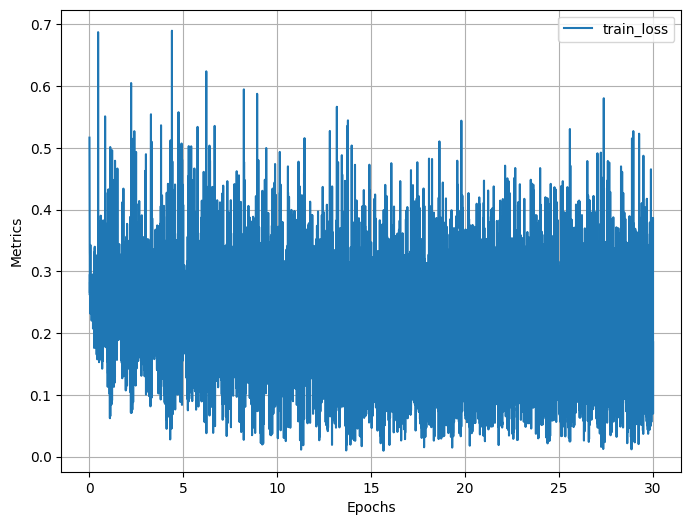

In [4]:
nn_mc_report.plot('train_ave_acc')
nn_mc_report.plot('train_acc')
nn_mc_report.plot('train_ave_loss')
nn_mc_report.plot('train_loss')

#### Evaluation

In [5]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_mc_model.eval()
def nn_mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_mc_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_mc_score, nn_mc_mse = eval.score_model(test_dataset, nn_mc_predict)

def nn_mc_predict_seq(sa_pair_seq):
    pred = nn_mc_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_mc_seq_score, nn_mc_seq_mse = eval.score_model_sequential(test_dataset, nn_mc_predict_seq)

print(f"NN MC Accuracy: {nn_mc_score}")
print(f"NN MC MSE: {nn_mc_mse}")
print(f"NN MC Seq Accuracy: {nn_mc_seq_score}")
print(f"NN MC Seq MSE: {nn_mc_seq_mse}")

NN MC Accuracy: 0.559850374064838
NN MC MSE: 0.2866736389226021
NN MC Seq Accuracy: 0.5947630922693267
NN MC Seq MSE: 0.2452030653631141


### SARSA

#### Training (Without MC Init)

In [6]:
import d_sarsa

nn_sarsa_model, nn_sarsa_report = d_sarsa.train(save=False, use_mc=False)

EPOCH: 1.000  train_ave_loss: 0.162  train_ave_acc: 0.514  (2.58s - 74.82s remaining) ave_loss: 0.16208185009177653 ave_acc: 0.514261795552118
EPOCH: 2.000  train_ave_loss: 0.151  train_ave_acc: 0.524  (5.13s - 71.86s remaining) ave_loss: 0.1510867671904501 ave_acc: 0.5238294210792803
EPOCH: 3.000  train_ave_loss: 0.146  train_ave_acc: 0.534  (7.74s - 69.62s remaining) ave_loss: 0.14588940894105568 ave_acc: 0.5337636280515768
EPOCH: 4.000  train_ave_loss: 0.144  train_ave_acc: 0.532  (10.75s - 69.85s remaining) ave_loss: 0.1442834193220149 ave_acc: 0.5316701219927026
EPOCH: 5.000  train_ave_loss: 0.142  train_ave_acc: 0.534  (13.63s - 68.16s remaining) ave_loss: 0.14219451354559828 ave_acc: 0.5341733687746711
EPOCH: 6.000  train_ave_loss: 0.142  train_ave_acc: 0.542  (16.44s - 65.74s remaining) ave_loss: 0.14178501546950983 ave_acc: 0.5421218965776382
EPOCH: 7.000  train_ave_loss: 0.124  train_ave_acc: 0.547  (19.14s - 62.90s remaining) ave_loss: 0.12424150143703583 ave_acc: 0.54720949

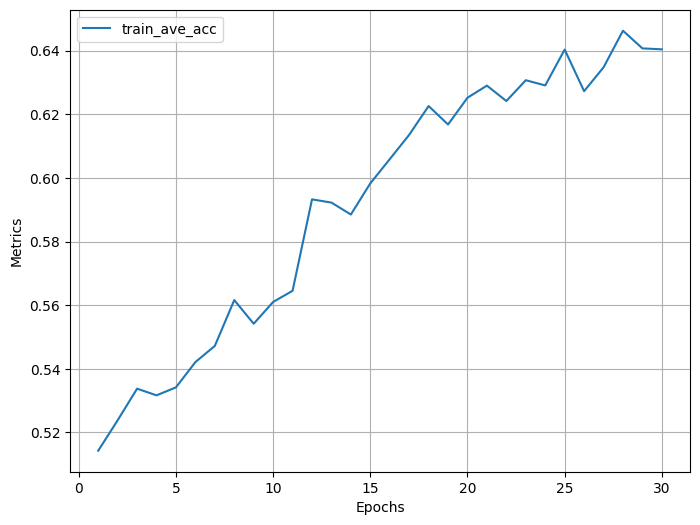

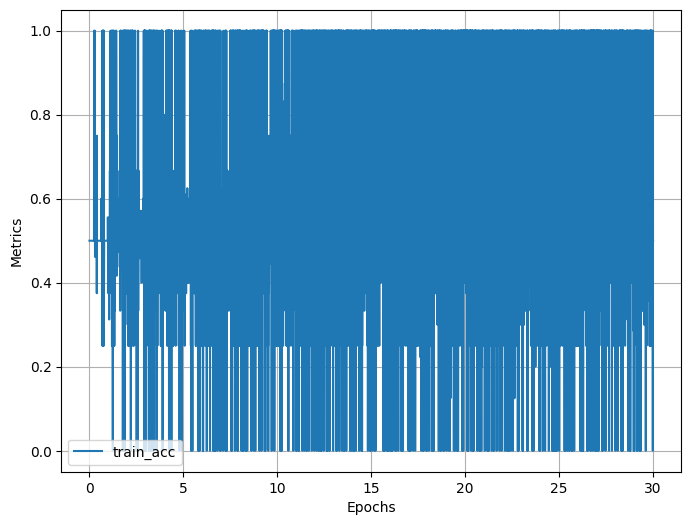

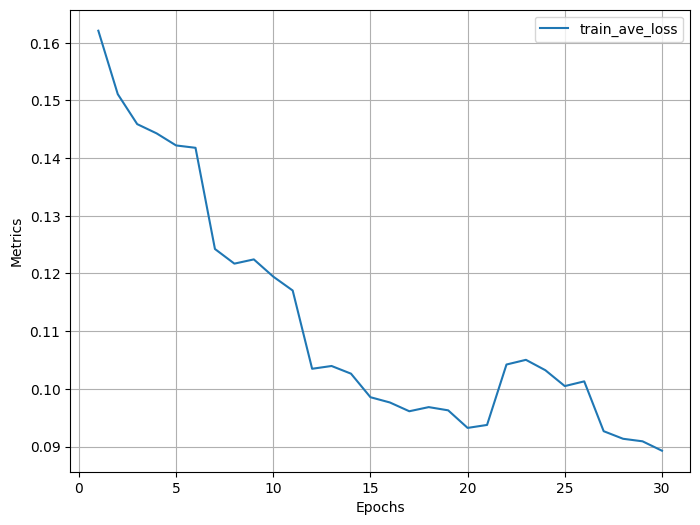

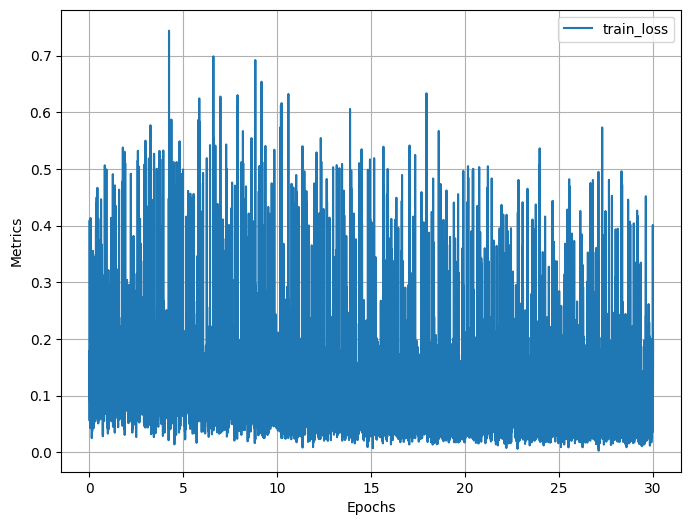

In [7]:
nn_sarsa_report.plot('train_ave_acc')
nn_sarsa_report.plot('train_acc')
nn_sarsa_report.plot('train_ave_loss')
nn_sarsa_report.plot('train_loss')

#### Evaluation (Without MC Init)

In [8]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_sarsa_model.eval()
def nn_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_sarsa_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_sarsa_score, nn_sarsa_mse = eval.score_model(test_dataset, nn_predict)

def nn_predict_seq(sa_pair_seq):
    pred = nn_sarsa_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_sarsa_seq_score, nn_sarsa_seq_mse = eval.score_model_sequential(test_dataset, nn_predict_seq)

print(f"NN Sarsa Accuracy: {nn_sarsa_score}")
print(f"NN Sarsa MSE: {nn_sarsa_mse}")
print(f"NN Sarsa Seq Accuracy: {nn_sarsa_seq_score}")
print(f"NN Sarsa Seq MSE: {nn_sarsa_seq_mse}")

NN Sarsa Accuracy: 0.516209476309227
NN Sarsa MSE: 0.30777767165007913
NN Sarsa Seq Accuracy: 0.5124688279301746
NN Sarsa Seq MSE: 0.262199406620914


#### Training (With MC Init)

In [9]:
import d_sarsa

nn_mc_state_dict = nn_mc_model.state_dict()
nn_sarsa_with_mc_model, nn_sarsa_with_mc_report = d_sarsa.train(save=False, use_mc=False, init_state_dict=nn_mc_state_dict)

Init state dictionary was passed. Using that to initialize model_net.
EPOCH: 1.000  train_ave_loss: 0.097  train_ave_acc: 0.714  (2.73s - 79.20s remaining) ave_loss: 0.09696794483985458 ave_acc: 0.7138849133963855
EPOCH: 2.000  train_ave_loss: 0.098  train_ave_acc: 0.680  (5.27s - 73.74s remaining) ave_loss: 0.09771062549793563 ave_acc: 0.680445894685299
EPOCH: 3.000  train_ave_loss: 0.095  train_ave_acc: 0.694  (7.81s - 70.27s remaining) ave_loss: 0.09531380244615403 ave_acc: 0.6935120100286027
EPOCH: 4.000  train_ave_loss: 0.095  train_ave_acc: 0.684  (10.37s - 67.39s remaining) ave_loss: 0.09463312630910328 ave_acc: 0.6836885964003853
EPOCH: 5.000  train_ave_loss: 0.093  train_ave_acc: 0.692  (12.89s - 64.46s remaining) ave_loss: 0.09275643217112443 ave_acc: 0.6924189839528244
EPOCH: 6.000  train_ave_loss: 0.092  train_ave_acc: 0.689  (15.44s - 61.76s remaining) ave_loss: 0.09211867073922257 ave_acc: 0.6886431261483994
EPOCH: 7.000  train_ave_loss: 0.094  train_ave_acc: 0.681  (17.9

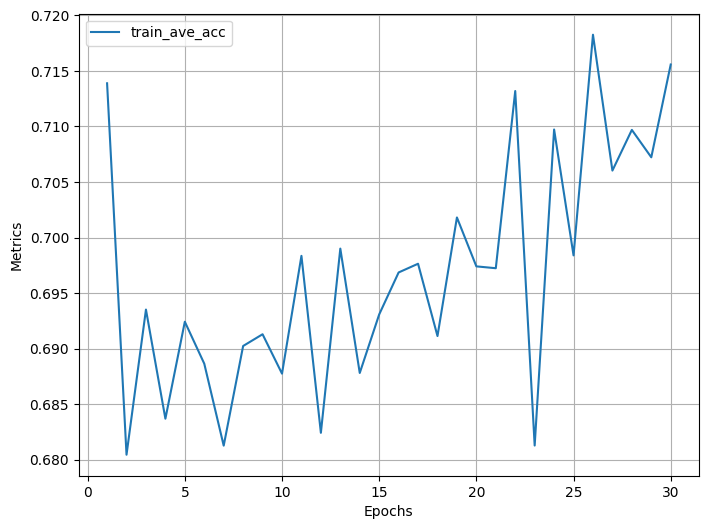

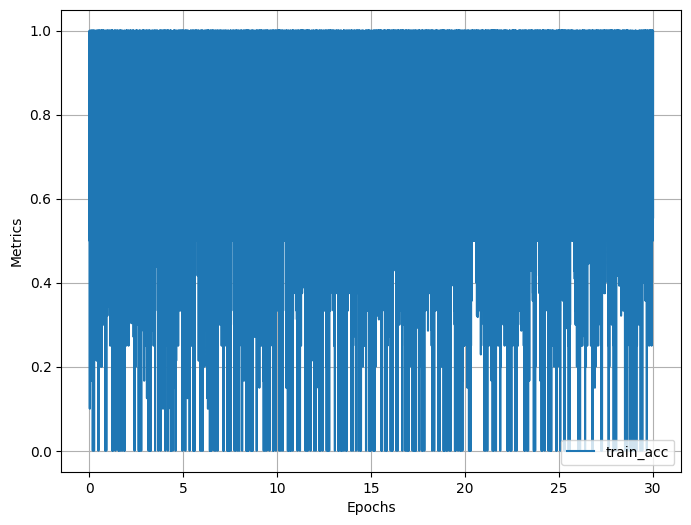

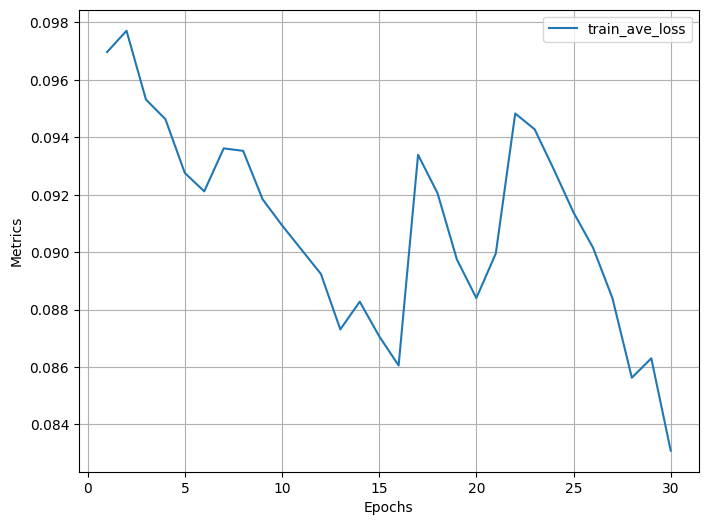

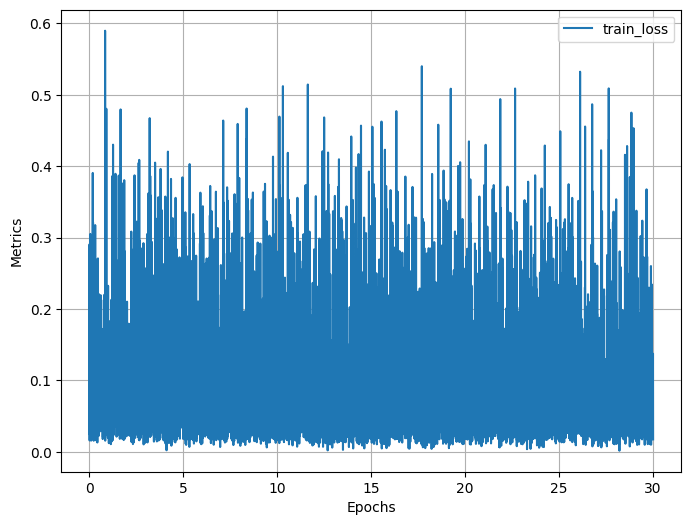

In [10]:
nn_sarsa_with_mc_report.plot('train_ave_acc')
nn_sarsa_with_mc_report.plot('train_acc')
nn_sarsa_with_mc_report.plot('train_ave_loss')
nn_sarsa_with_mc_report.plot('train_loss')

#### Evaluation (With MC Init)

In [11]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_sarsa_with_mc_model.eval()
def nn_sarsa_with_mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_sarsa_with_mc_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_sarsa_with_mc_score, nn_sarsa_with_mc_mse = eval.score_model(test_dataset, nn_sarsa_with_mc_predict)

def nn_sarsa_with_mc_predict_seq(sa_pair_seq):
    pred = nn_sarsa_with_mc_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_sarsa_with_mc_seq_score, nn_sarsa_with_mc_seq_mse = eval.score_model_sequential(test_dataset, nn_sarsa_with_mc_predict_seq)

print(f"NN Sarsa With MC Init Accuracy: {nn_sarsa_with_mc_score}")
print(f"NN Sarsa With MC Init MSE: {nn_sarsa_with_mc_mse}")
print(f"NN Sarsa With MC Init Seq Accuracy: {nn_sarsa_with_mc_seq_score}")
print(f"NN Sarsa With MC Init Seq MSE: {nn_sarsa_with_mc_seq_mse}")

NN Sarsa With MC Init Accuracy: 0.5536159600997507
NN Sarsa With MC Init MSE: 0.30079815669240884
NN Sarsa With MC Init Seq Accuracy: 0.5885286783042394
NN Sarsa With MC Init Seq MSE: 0.25443798161153386


In [14]:
import os

model_dirpath = 'experiment_models/vanilla_paper_params'
os.makedirs(model_dirpath, exist_ok=True)


torch.save(nn_mc_model.state_dict(), os.path.join(model_dirpath, 'nn_mc_model.pth'))
torch.save(nn_sarsa_model.state_dict(), os.path.join(model_dirpath, 'nn_sarsa_model.pth'))
torch.save(nn_sarsa_with_mc_model.state_dict(), os.path.join(model_dirpath, 'nn_sarsa_with_mc_model.pth'))

## Conclusion

### Summary

### Future extensions